In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from numpy.linalg import eig
import os
from PointDistributionModel import PointDistributionModel 
from scipy.linalg import svd

In [48]:
df = pd.DataFrame([], columns=['Patient','Landmark','X','Y'])
fileCount = 0
for file in os.listdir('Data'):
    data = np.loadtxt('Data/'+file, delimiter=',', skiprows=1)
    tmp = pd.DataFrame(data, columns=['Landmark', 'X', 'Y'])
    tmp['Patient'] = file
    df = pd.concat((df,tmp))
    fileCount +=1

df = df.loc[(df.Landmark != 9)]# & (df.Landmark != 18)]

shapeList = []
for patient in np.unique(df.Patient.values):
    shape = df.loc[df.Patient==patient, ['X','Y']].to_numpy()
    shapeList.append(shape)


df.to_csv('Landmark.csv')

In [49]:
PDM = PointDistributionModel(shapeList)
PDM.fit()

Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=2.849722888181951.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.


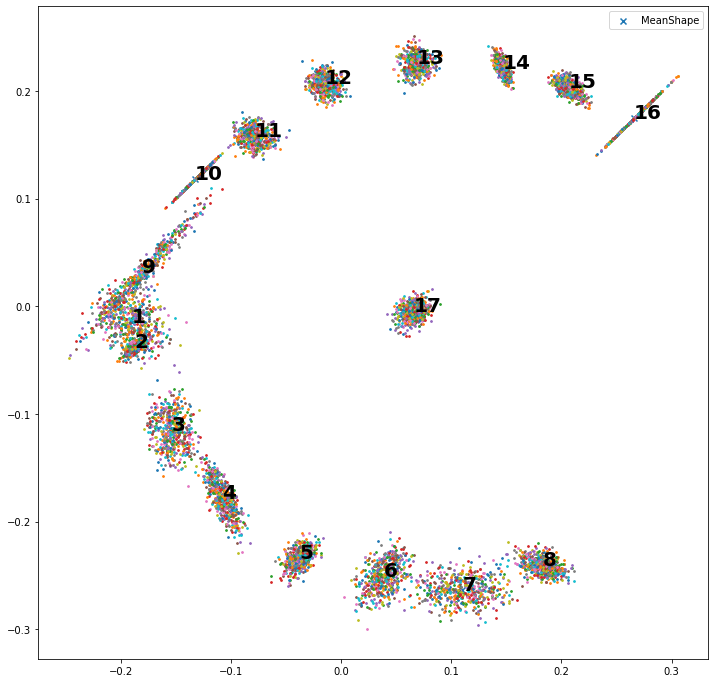

In [50]:
generatedShapes = PDM.generate(500)


fig, ax = plt.subplots(figsize=(12,12))
xmean, ymean = PDM._meanShape[::2],PDM._meanShape[1::2]
ax.scatter(xmean, ymean, label='MeanShape', marker='x')
for i in range(xmean.size):
    ax.annotate(i+1, (xmean[i],ymean[i]), weight='bold', size=20)   

for shape in generatedShapes:
    ax.scatter(shape[:,0], shape[:,1], s=3)
plt.legend()


Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
	Distance between mean shape and reference shape dist=0.9490150313775774.
(34, 12)
Real part 5.275577707787114 vs imaginary part 2.4836021921998


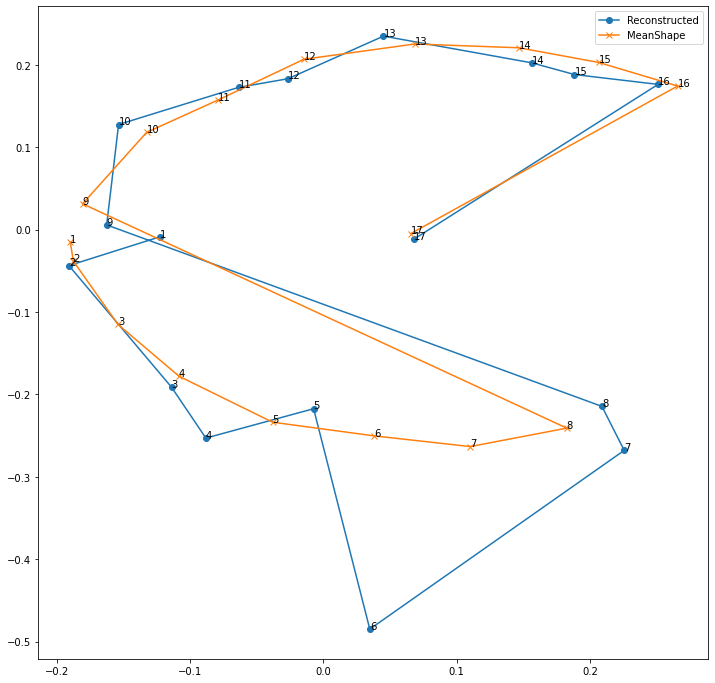

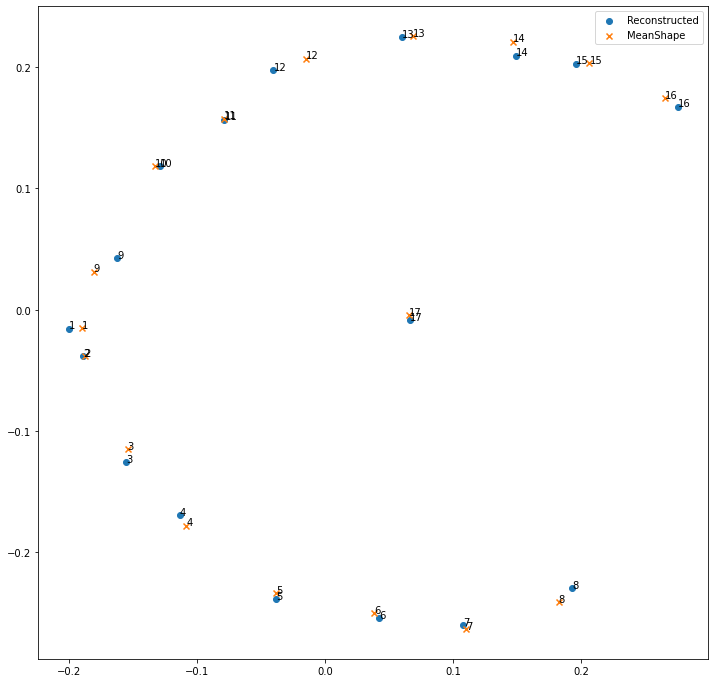

In [51]:

newShapes, meanShape = PointDistributionModel.GeneralizedProcrustesAnalysis(shapeList, maxIter=5)
df = pd.DataFrame([], columns=['Shape', 'Landmark', 'X', 'Y'])
for i, shape in enumerate(newShapes):
    tmp = pd.DataFrame(np.zeros((shape.shape[0],4)), columns=['Shape', 'Landmark', 'X', 'Y'])
    tmp['X'] = shape[:,0]
    tmp['Y'] = shape[:,1]
    tmp.Shape = i+1
    tmp.Landmark = np.arange(1, shape.shape[0]+1)
    df = pd.concat((df, tmp))
df = df.set_index(['Shape', 'Landmark'])
df.to_csv('Landmarks_Aligned.csv')
df
df = pd.read_csv('Landmarks_Aligned.csv', index_col=(0,1))
shapes = df.index.get_level_values('Shape').drop_duplicates()
n = shapes.size
data = np.zeros((2*df.index.get_level_values('Landmark').drop_duplicates().size, n))
for i, shape in enumerate(shapes):
    landmarks = df.loc[shape].values[:,:].ravel().T
    data[:,i] = landmarks   
print(data.shape)
pca = PCA(whiten=True)
pca.fit(data.T)
cov = pca.get_covariance()
eigva, eigve = eig(cov)
P = np.real(eigve).T
print(f'Real part {np.linalg.norm(P)} vs imaginary part {np.linalg.norm(np.imag(eigve))}')
stds = np.sqrt(np.abs(eigva))
meanShape = np.zeros((data.shape[0],))
m,N = data.shape
for i in range(N):
    meanShape += data[:,i]
meanShape /= N
meanShape = meanShape.reshape((meanShape.shape[0],1))
b = np.random.normal(0.0, stds*10)
xn = meanShape[:,0] + P.dot(b)
x,y = xn[::2], xn[1::2]
fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.plot(x,y, label='Reconstructed', marker='o')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.plot(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()
W = (data-meanShape.dot(np.ones((1,N))))/(np.sqrt(N-1))
U,s,V = svd(W.T, full_matrices=True)
p = V.shape[0]
b = np.random.normal(0.0, scale=3*stds)
xn = meanShape[:,0] + V.dot(b)
x,y = xn[::2], xn[1::2]

fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.scatter(x,y, label='Reconstructed')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.scatter(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()